<a href="https://colab.research.google.com/github/busedagidir/blip-image-captioning-huggingface/blob/master/blip_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/huggingface/transformers.git@main

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-ome1m3vt
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-ome1m3vt
  Resolved https://github.com/huggingface/transformers.git to commit 17a55534f5e5df10ac4804d4270bf6b8cc24998d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.30.0.dev0-py3-none-any.whl size=7102950 sha256=a256b1b4745ae20775d30df2ccde5ae32983f7f51b84132eebb6d0490450aca7
  Stored

In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.5 MB/s eta 0:00:00


In [3]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_captioning_blip_notebook", framework="pytorch")

In [4]:
# Load the image captioning dataset

from datasets import load_dataset
dataset = load_dataset("ybelkada/football-dataset", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ybelkada___parquet/ybelkada--football-dataset-1ad065f8e9005a29/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [6]:
dataset[1]["text"]

'Maradona after winning the 1986 FIFA World Cup with Argentina'

In [11]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    item = self.dataset[idx]
    encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

    # remove batch dimension
    encoding = {k:v.squeeze() for k,v in encoding.items()}
    return encoding



Load model and processor

In [12]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [13]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [14]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 13.092949867248535
Loss: 10.26405143737793
Loss: 10.212059020996094
Epoch: 1
Loss: 10.188398361206055
Loss: 10.199752807617188
Loss: 10.172483444213867
Epoch: 2
Loss: 10.161948204040527
Loss: 10.105613708496094
Loss: 10.153085708618164
Epoch: 3
Loss: 10.13394546508789
Loss: 10.098095893859863
Loss: 10.089159965515137
Epoch: 4
Loss: 10.092098236083984
Loss: 10.062491416931152
Loss: 10.058502197265625
Epoch: 5
Loss: 10.009876251220703
Loss: 10.030035018920898
Loss: 10.043741226196289
Epoch: 6
Loss: 9.936356544494629
Loss: 9.873942375183105
Loss: 9.57394790649414
Epoch: 7
Loss: 9.301620483398438
Loss: 9.005855560302734
Loss: 8.780816078186035
Epoch: 8
Loss: 8.546785354614258
Loss: 8.37388801574707
Loss: 8.160112380981445
Epoch: 9
Loss: 7.959931373596191
Loss: 7.800540924072266
Loss: 7.651716232299805
Epoch: 10
Loss: 7.5058746337890625
Loss: 7.327543258666992
Loss: 7.1800360679626465
Epoch: 11
Loss: 7.053761959075928
Loss: 6.876962661743164
Loss: 6.774281024932861
Epoch: 12


Inference

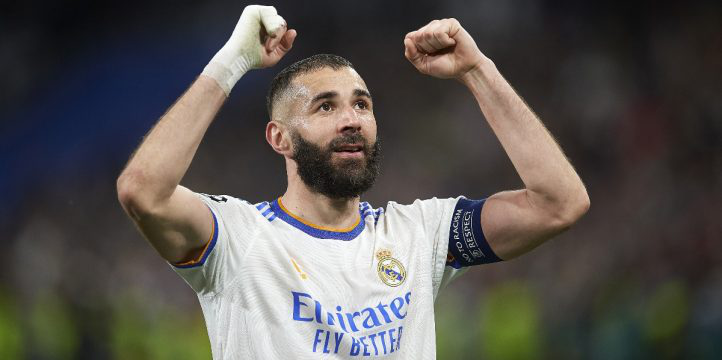

In [15]:
# load image
example = dataset[0]
image = example["image"]
image

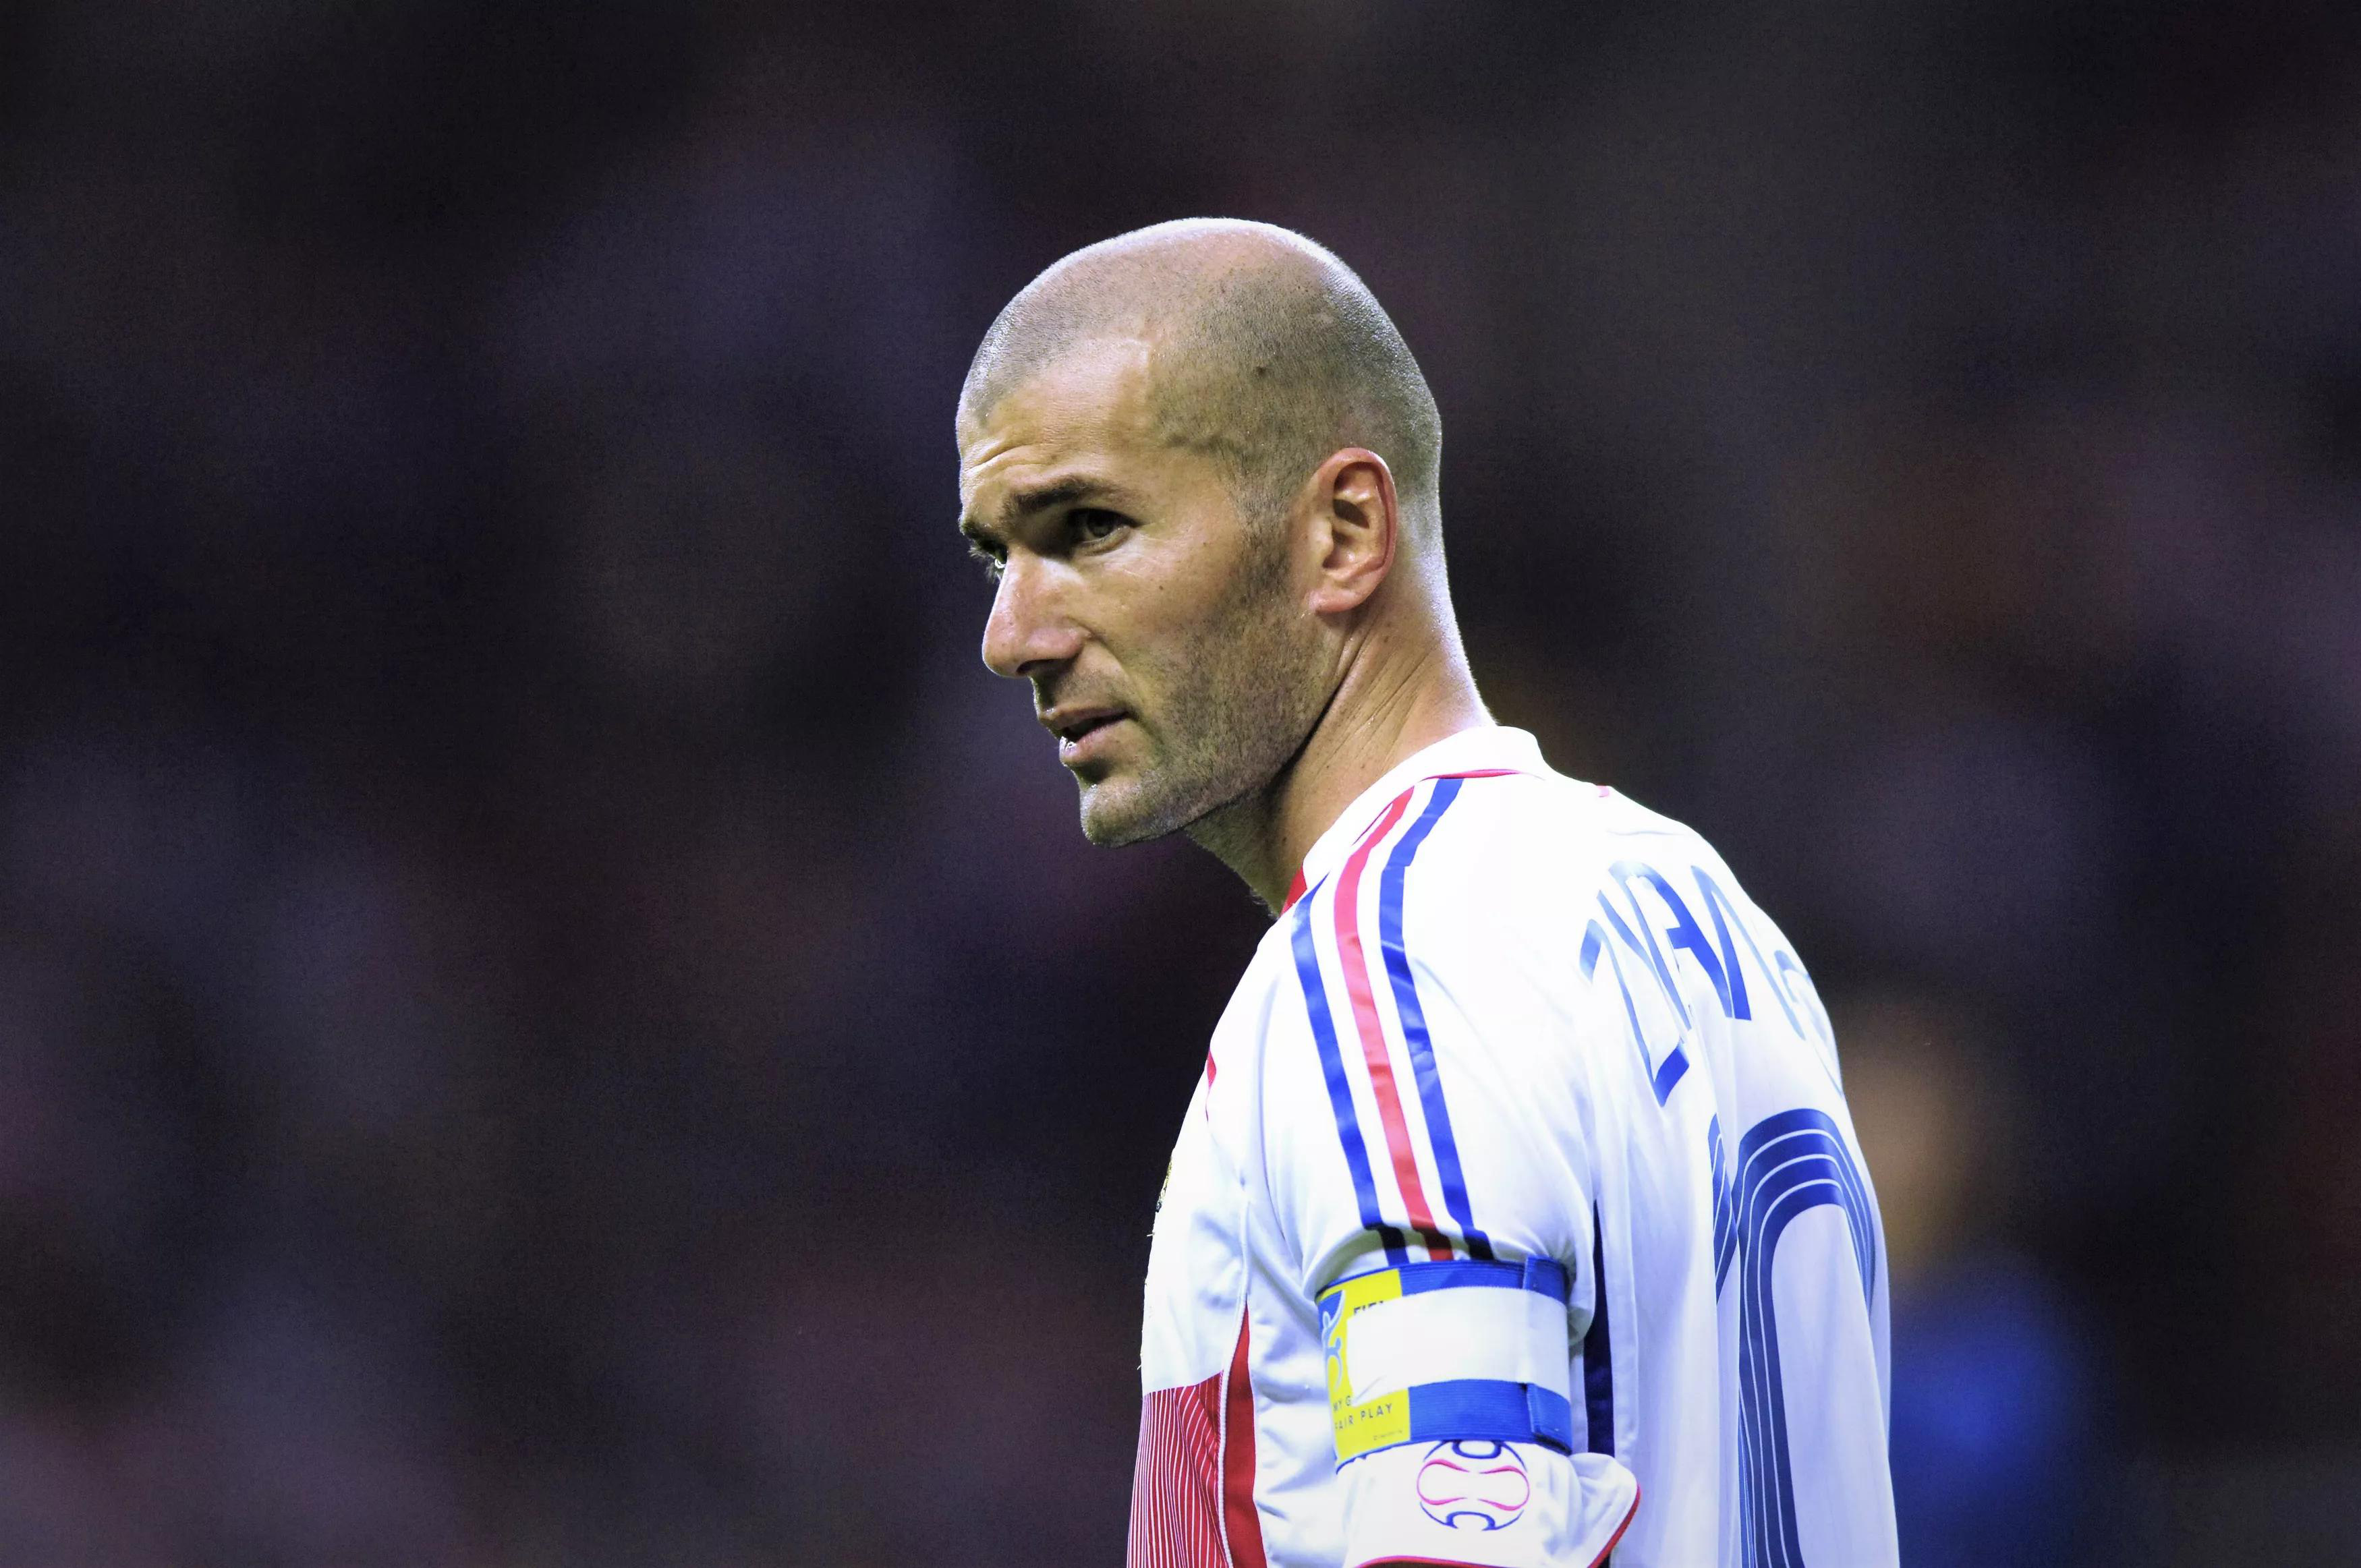

In [22]:
example = dataset[5]
image = example["image"]
image

In [23]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

zidane with france in 2006 world cup


In [24]:
dataset.info

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(decode=True, id=None), 'text': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, config_name=None, version=None, splits={'train': SplitInfo(name='train', num_bytes=2073646, num_examples=6, shard_lengths=None, dataset_name='parquet')}, download_checksums={'https://huggingface.co/datasets/ybelkada/football-dataset/resolve/7d02c47036a5eddb519c924eb937f3ccaceb5743/data/train-00000-of-00001-fc7c825a21687306.parquet': {'num_bytes': 2074835, 'checksum': None}}, download_size=2074835, post_processing_size=None, dataset_size=2073646, size_in_bytes=4148481)

In [25]:
len(dataset)

6

In [26]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

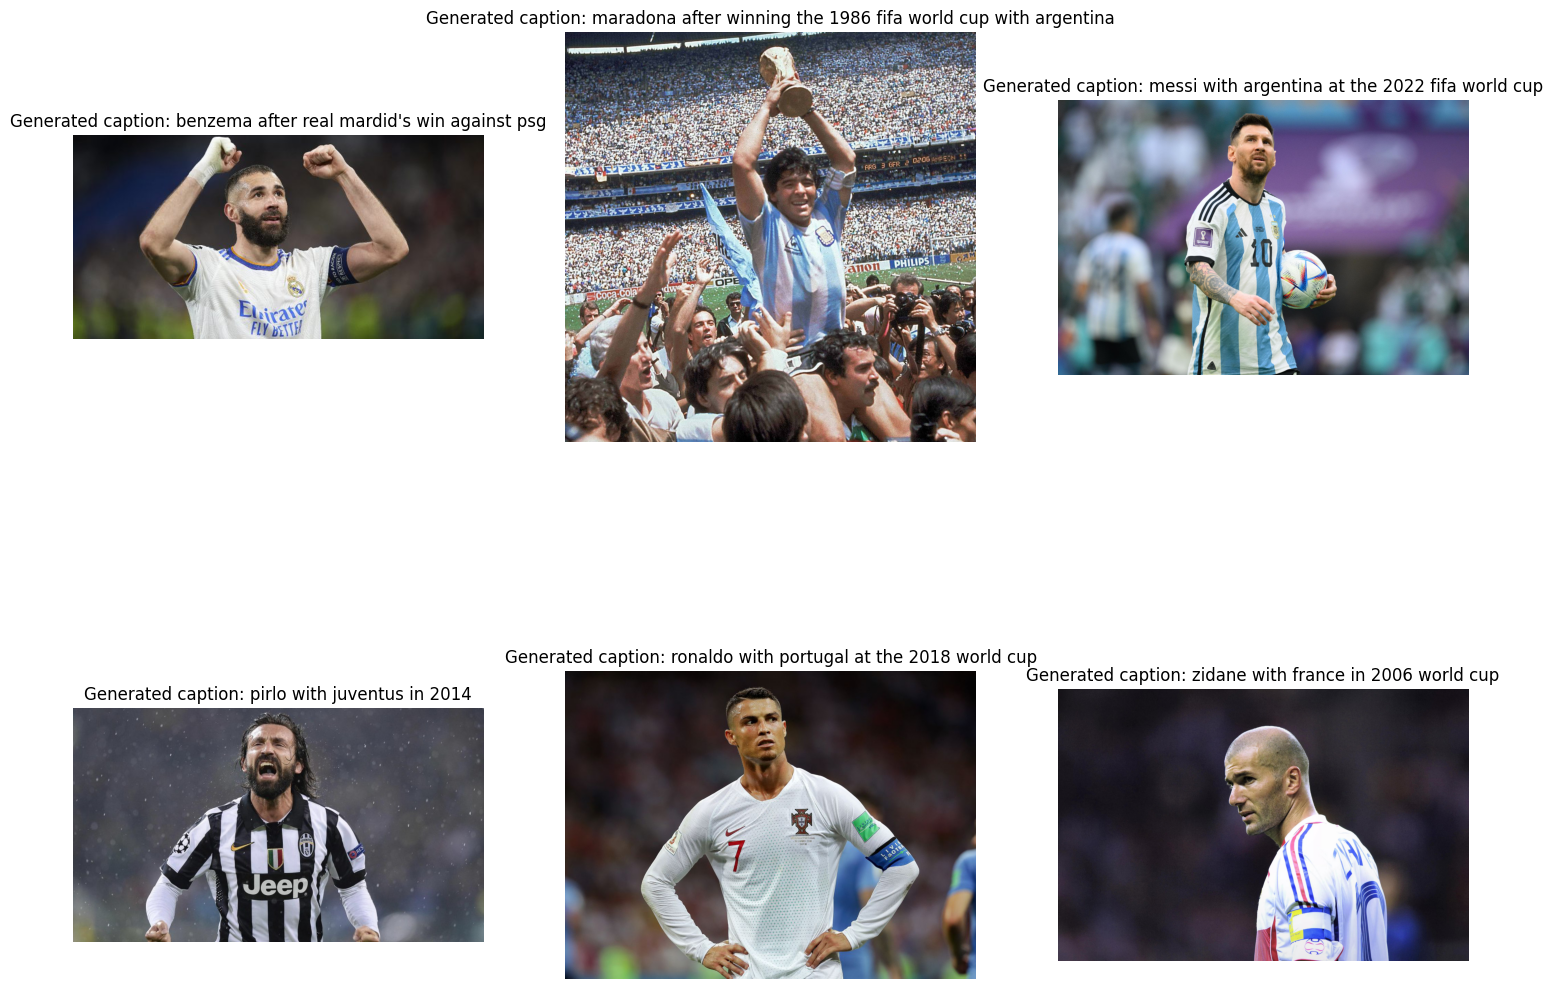

In [27]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")